In [1]:
from glob import glob

filenames = glob('scenes/*.jpg') #importing file names
print(filenames[:10])

['scenes/coast_n672003.jpg', 'scenes/opencountry_cdmc109.jpg', 'scenes/highway_gre474.jpg', 'scenes/forest_natu169.jpg', 'scenes/opencountry_land406.jpg', 'scenes/opencountry_nat1122.jpg', 'scenes/street_art379.jpg', 'scenes/opencountry_nat718.jpg', 'scenes/mountain_land879.jpg', 'scenes/tallbuilding_art1725.jpg']


In [9]:
#get class name from file name

classes = list(map(lambda x: x.split('/')[1].split('_')[0], filenames))
print(classes[:10])

['coast', 'opencountry', 'highway', 'forest', 'opencountry', 'opencountry', 'street', 'opencountry', 'mountain', 'tallbuilding']


In [10]:
import pandas as pd

data = pd.DataFrame({'filename':filenames, 'class':classes})
data.head()

,filename,class
0,scenes/coast_n672003.jpg,coast
1,scenes/opencountry_cdmc109.jpg,opencountry
2,scenes/highway_gre474.jpg,highway
3,scenes/forest_natu169.jpg,forest
4,scenes/opencountry_land406.jpg,opencountry


In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(123)
data_train,data_test = train_test_split(data, test_size=0.25)
print(len(data_train), len(data_test))
data_train.head()

2016 672


,filename,class
2065,scenes/highway_gre400.jpg,highway
633,scenes/mountain_ski5.jpg,mountain
1955,scenes/mountain_n219007.jpg,mountain
970,scenes/street_art862.jpg,street
515,scenes/forest_nat212.jpg,forest


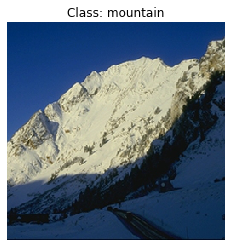

In [20]:
#let's visualize image from dataset using pyplot and io
from matplotlib import pyplot as plt
from skimage import io

def showImage(data,index):
    row = data.iloc[index]
    im = io.imread(row['filename'])
    plt.title(f"Class: {row['class']}")
    plt.axis('off')
    plt.imshow(im)

showImage(data_train, 1)            

# Create a data subset

We are going to do this just for speed (take 5% of the images)

In [22]:
_, data_small = train_test_split(data, test_size=0.05)
np.random.seed(145)
len(data_small)

135

In [31]:
#lets create a training and test from this small subset
train_small, test_small = train_test_split(data_small, test_size=0.15)
print(len(train_small), len(test_small))

114 21


# Building Bag of Visual Words, Patch Extraction and SIFT

In [35]:
#we need to grayscale the image before passing to the function
from cyvlfeat.sift import dsift

im = io.imread(train_small.iloc[0]['filename'],as_gray=True)
positions, descriptors = dsift(im)

#the function returns the position of the extracted patches and the extracted descriptors

print(positions.shape)
print(descriptors.shape)
print(positions[:3])

(61009, 2)
(61009, 128)
[[4.5 4.5]
 [4.5 5.5]
 [4.5 6.5]]


# Domanda 1

The number of columns of descriptors is equal to 128 because SIFT represents the image as a vector of 4x4x8 dimensions (concatenates the weighted histograms)

# Change the parameters of sift

(625, 2) (625, 128)


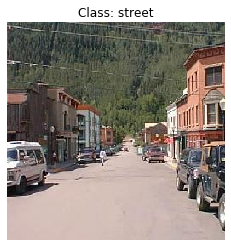

In [36]:
positions, descriptors = dsift(im, size=5, step=10)
print(positions.shape, descriptors.shape)

showImage(train_small, 0)

# Domanda 2

The size of each patch is 4x5=20px. The sampling step is 10px, so we should have an overlap of 10 px. The size of the descriptors is not the same as before beacause the number of patches has changed

# Plotting the descriptors (WEIGHTED HISTOGRAMS)

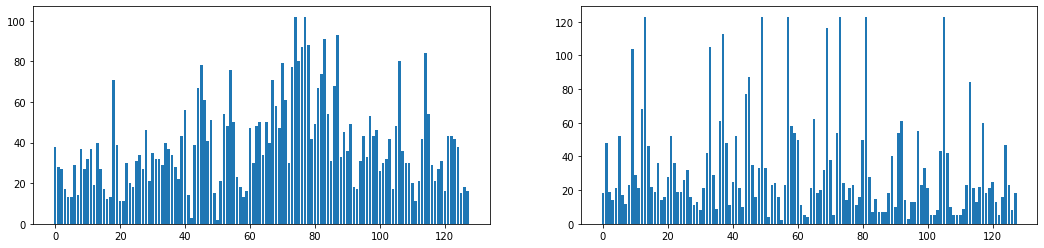

In [41]:
np.random.seed(16)

idx1,idx2 = np.random.choice(len(descriptors), 2) #prendi un descriptor casuale e dammi due valori
d1 = descriptors[idx1]
d2 = descriptors[idx2]

plt.figure(figsize=(18,4))
plt.subplot(121) #un grafico 1x2 e vai a posizionarti nel primo grafico 
plt.bar(range(len(d1)), d1) #dammi da 0 a 127 e con d1 indichiami l'altezza della barra
plt.subplot(122)
plt.bar(range(len(d2)),d2)
plt.show()

# Domanda 3

We have got 128 bars in each plot, the descriptors are not similar

In [42]:
# Describe patches from different images

im0 = io.imread(train_small.iloc[0]['filename'], as_gray=True)
im1 = io.imread(train_small.iloc[1]['filename'], as_gray=True)
im2 = io.imread(train_small.iloc[2]['filename'], as_gray=True)

_, descriptors0 = dsift(im0, size=5, step=10)
_, descriptors1 = dsift(im1, size=5, step=10)
_, descriptors2 = dsift(im2, size=5, step=10)

all_descriptors = np.vstack([descriptors0, descriptors1, descriptors2])
print(all_descriptors.shape)

(1875, 128)


# Function that extract all the descriptors from all the images of the DataFrame

In [44]:
from tqdm import tqdm

def extract_and_describe(data, size=5, step=10):
    descriptors = []
    for i, row in tqdm(data.iterrows(), "Extracting/Describing Patches", total=len(data)):
        im = io.imread(row['filename'], as_gray=True)
        _, desc = dsift(im, size=size, step=step)
        descriptors.append(desc)
    return np.vstack(descriptors)

train_descriptors = extract_and_describe(train_small)
print(train_descriptors.shape)

Extracting/Describing Patches: 100%|██████████| 114/114 [00:11<00:00, 10.18it/s]

(71250, 128)
